<a href="https://colab.research.google.com/github/23Aditya/APS-Failure-Prediction/blob/master/Semi_Supervised_learning_MelanomaDetectionFinal_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Dependencies

import os
import cv2
import time
import keras
import shutil
import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from random import randint
from IPython import display
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imutils import build_montages
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout
from keras.layers import Dense,Reshape,Conv2DTranspose,BatchNormalization, Activation, UpSampling2D, ZeroPadding2D

In [2]:
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection",
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

Found 7018 images belonging to 1 classes.


In [3]:
def discriminator():

  dis = Sequential(name="Discriminator")

  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())
  dis.add(Dropout(0.3))

  dis.add(Dense(units=1,activation="sigmoid"))

  return dis

def generator():

  noise_shape = 100
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))
  gen.add(Reshape((4,4,100)))

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen

In [4]:
D = discriminator()
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524288    
                                                     

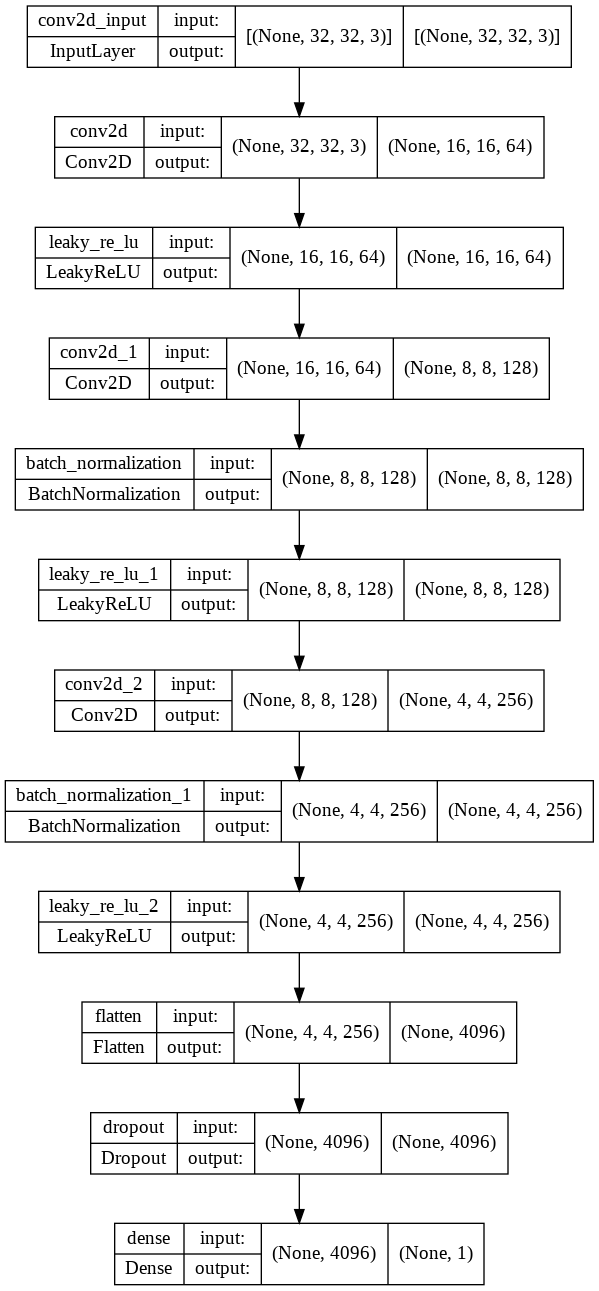

In [5]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

In [6]:
G = generator()
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        52

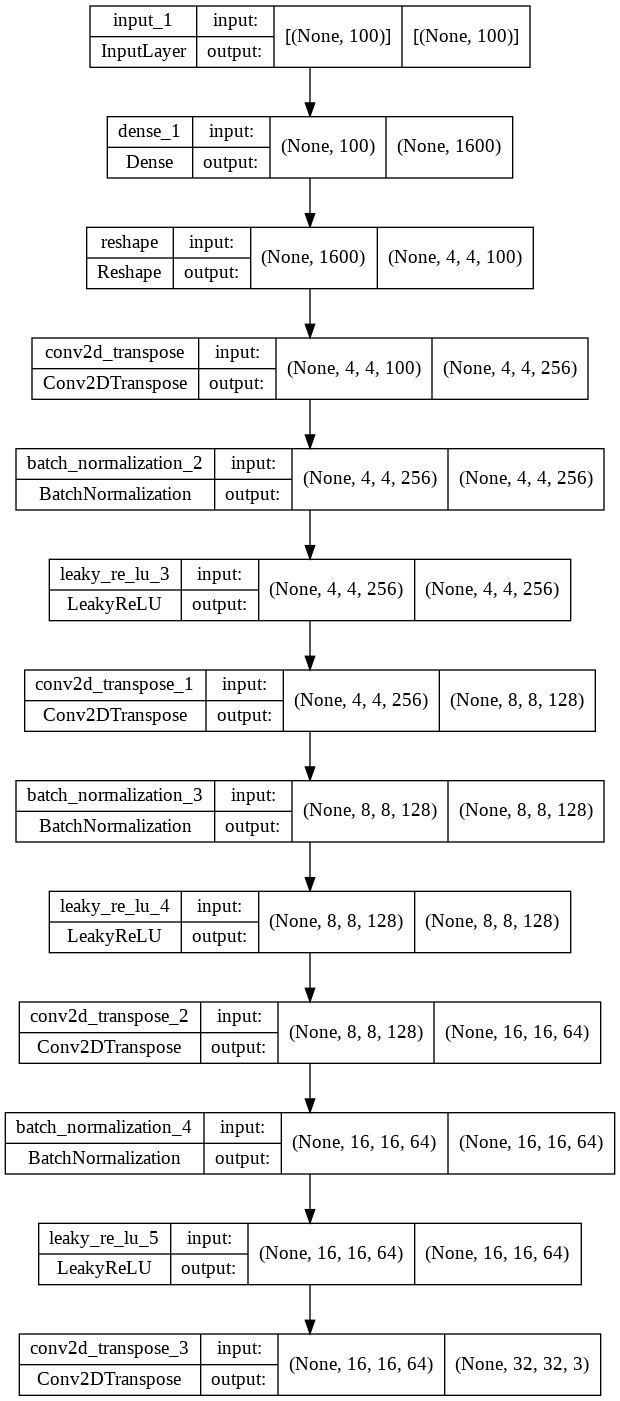

In [7]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

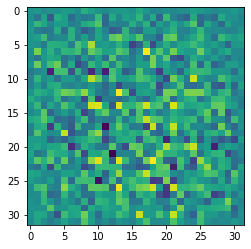

In [8]:
random_noise = tf.random.normal(shape=(1,100))
generated_image = G(random_noise,training=False)
plt.imshow(generated_image[0,:,:,0])

In [9]:
posterior = D(generated_image)
print(posterior)

tf.Tensor([[0.5001786]], shape=(1, 1), dtype=float32)


In [10]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
# taking few epochs and se what is happening
GAN_epochs = 50
noise_shape = 100
batch_size = 256

In [13]:
GENERATE_RES = 1 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/MyDrive/MelanomaDetection/unlabeled'
EPOCHS = 50
BATCH_SIZE = 256
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 32px square images.


In [14]:
# here we r doing a normatization...
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  # print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/MyDrive/MelanomaDetection/unlabeled/training_data_32_32.npy
Loading previous training pickle...


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [16]:
# def G_loss(fake_imgs_preds):

#   fake_imgs_labels = tf.ones_like(fake_imgs_preds)

#   return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [17]:
D_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
G_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [18]:
# GAN_checkpoint_dir = "/content/drive/MyDrive/GAN_training_checkpoints"
# GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
# GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [19]:
@tf.function
def training_step(real_imgs_mini_batch):

  # G.trainable = False
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  # D.trainable = True

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

    D.trainable = False
    G.trainable = True

    #noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_imgs_mini_batch = G(noise,training=True)

    fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    gen_loss = G_loss(fake_imgs_preds)

    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

In [20]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [21]:
def generate_and_save_images(generator_model,epoch,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(7,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(7,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [22]:
real_imgs_path = "/content/drive/MyDrive/MelanomaDetection/unlabeled"

In [23]:
def train_gan(real_imgs_datagen,total_epochs):
  constant_noise = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,SEED_SIZE))
  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:
     
      # print(image_batch.shape)
      print("Training GAN at Time Step {} of Epoch {}".format(time_step,epoch+1))

      G.trainable = False
      
      
      print('1')

      D.trainable = True

      with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        
        noise = tf.random.normal([BATCH_SIZE, SEED_SIZE])
        generated_imgs_mini_batch = G(noise,training=False)
       

        real_imgs_preds = D(image_batch,training=True)
        fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

        disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)
        print(f'****************** for time_step {time_step}, discriminator loss is {disc_loss} ***********************')

        gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
        D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

        D.trainable = False
        G.trainable = True

        # noise = tf.random.normal(shape=(batch_size,noise_shape))
        # generated_imgs_mini_batch = G(noise,training=True)

        # fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

        gen_loss = G_loss(fake_imgs_preds)
        print(f'****************** for time_step {time_step}, generator loss is {gen_loss} ***********************')

        gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
        G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))


      # training_step(real_imgs_mini_batch=image_batch[0])

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    # if (epoch + 1) % 5 == 0:
    #   GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

Training GAN at Time Step 1 of Epoch 1
1
****************** for time_step 1, discriminator loss is 1.2700382471084595 ***********************
****************** for time_step 1, generator loss is 0.8772421479225159 ***********************
Training GAN at Time Step 2 of Epoch 1
1
****************** for time_step 2, discriminator loss is 1.0977696180343628 ***********************
****************** for time_step 2, generator loss is 0.5622590780258179 ***********************
Training GAN at Time Step 3 of Epoch 1
1
****************** for time_step 3, discriminator loss is 1.0160471200942993 ***********************
****************** for time_step 3, generator loss is 0.5913696885108948 ***********************
Training GAN at Time Step 4 of Epoch 1
1
****************** for time_step 4, discriminator loss is 0.8433195948600769 ***********************
****************** for time_step 4, generator loss is 0.75226891040802 ***********************
Training GAN at Time Step 5 of Epoch 1
1
*****

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

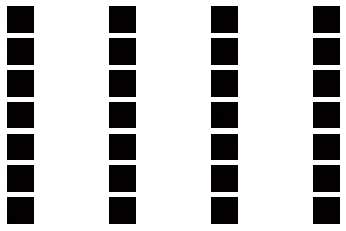

Training GAN at Time Step 1 of Epoch 2
1
****************** for time_step 1, discriminator loss is 0.18951508402824402 ***********************
****************** for time_step 1, generator loss is 2.369788408279419 ***********************
Training GAN at Time Step 2 of Epoch 2
1
****************** for time_step 2, discriminator loss is 0.20110103487968445 ***********************
****************** for time_step 2, generator loss is 2.343822479248047 ***********************
Training GAN at Time Step 3 of Epoch 2
1
****************** for time_step 3, discriminator loss is 0.21012583374977112 ***********************
****************** for time_step 3, generator loss is 2.323545217514038 ***********************
Training GAN at Time Step 4 of Epoch 2
1
****************** for time_step 4, discriminator loss is 0.2115650177001953 ***********************
****************** for time_step 4, generator loss is 2.340620756149292 ***********************
Training GAN at Time Step 5 of Epoch 2
1
****

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

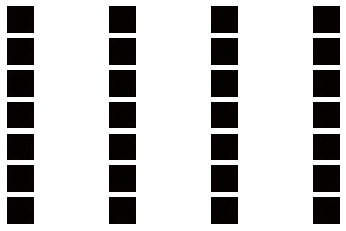

Training GAN at Time Step 1 of Epoch 3
1
****************** for time_step 1, discriminator loss is 0.11206085979938507 ***********************
****************** for time_step 1, generator loss is 2.848802089691162 ***********************
Training GAN at Time Step 2 of Epoch 3
1
****************** for time_step 2, discriminator loss is 0.0962771624326706 ***********************
****************** for time_step 2, generator loss is 2.96069073677063 ***********************
Training GAN at Time Step 3 of Epoch 3
1
****************** for time_step 3, discriminator loss is 0.09264995157718658 ***********************
****************** for time_step 3, generator loss is 3.1312410831451416 ***********************
Training GAN at Time Step 4 of Epoch 3
1
****************** for time_step 4, discriminator loss is 0.0896984189748764 ***********************
****************** for time_step 4, generator loss is 3.158325672149658 ***********************
Training GAN at Time Step 5 of Epoch 3
1
*****

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

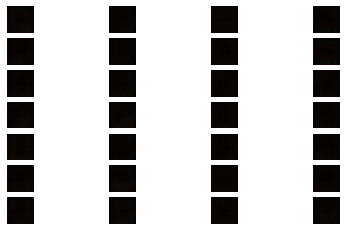

Training GAN at Time Step 1 of Epoch 4
1
****************** for time_step 1, discriminator loss is 0.036619238555431366 ***********************
****************** for time_step 1, generator loss is 4.410645484924316 ***********************
Training GAN at Time Step 2 of Epoch 4
1
****************** for time_step 2, discriminator loss is 0.04231634736061096 ***********************
****************** for time_step 2, generator loss is 4.285276412963867 ***********************
Training GAN at Time Step 3 of Epoch 4
1
****************** for time_step 3, discriminator loss is 0.037983305752277374 ***********************
****************** for time_step 3, generator loss is 4.291969299316406 ***********************
Training GAN at Time Step 4 of Epoch 4
1
****************** for time_step 4, discriminator loss is 0.035864248871803284 ***********************
****************** for time_step 4, generator loss is 4.210483074188232 ***********************
Training GAN at Time Step 5 of Epoch 4
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

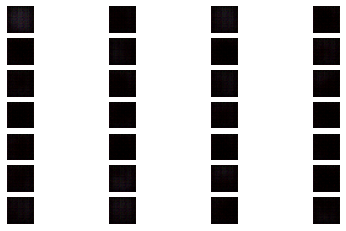

Training GAN at Time Step 1 of Epoch 5
1
****************** for time_step 1, discriminator loss is 0.022773005068302155 ***********************
****************** for time_step 1, generator loss is 4.613449573516846 ***********************
Training GAN at Time Step 2 of Epoch 5
1
****************** for time_step 2, discriminator loss is 0.019152939319610596 ***********************
****************** for time_step 2, generator loss is 4.989372253417969 ***********************
Training GAN at Time Step 3 of Epoch 5
1
****************** for time_step 3, discriminator loss is 0.020380744710564613 ***********************
****************** for time_step 3, generator loss is 5.046680927276611 ***********************
Training GAN at Time Step 4 of Epoch 5
1
****************** for time_step 4, discriminator loss is 0.020688623189926147 ***********************
****************** for time_step 4, generator loss is 4.984847068786621 ***********************
Training GAN at Time Step 5 of Epoch 5
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

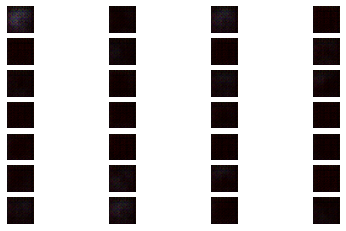

Training GAN at Time Step 1 of Epoch 6
1
****************** for time_step 1, discriminator loss is 0.014312760904431343 ***********************
****************** for time_step 1, generator loss is 5.0337324142456055 ***********************
Training GAN at Time Step 2 of Epoch 6
1
****************** for time_step 2, discriminator loss is 0.0131025156006217 ***********************
****************** for time_step 2, generator loss is 5.472986221313477 ***********************
Training GAN at Time Step 3 of Epoch 6
1
****************** for time_step 3, discriminator loss is 0.014131548814475536 ***********************
****************** for time_step 3, generator loss is 5.32298469543457 ***********************
Training GAN at Time Step 4 of Epoch 6
1
****************** for time_step 4, discriminator loss is 0.018116939812898636 ***********************
****************** for time_step 4, generator loss is 5.202253341674805 ***********************
Training GAN at Time Step 5 of Epoch 6
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 6
1
****************** for time_step 28, discriminator loss is 0.19993092119693756 ***********************
****************** for time_step 28, generator loss is 2.7382967472076416 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

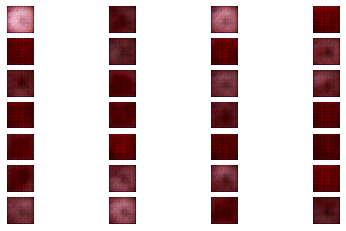

Training GAN at Time Step 1 of Epoch 7
1
****************** for time_step 1, discriminator loss is 0.11417631804943085 ***********************
****************** for time_step 1, generator loss is 3.1327579021453857 ***********************
Training GAN at Time Step 2 of Epoch 7
1
****************** for time_step 2, discriminator loss is 0.13032940030097961 ***********************
****************** for time_step 2, generator loss is 3.458561420440674 ***********************
Training GAN at Time Step 3 of Epoch 7
1
****************** for time_step 3, discriminator loss is 0.12882748246192932 ***********************
****************** for time_step 3, generator loss is 3.9279136657714844 ***********************
Training GAN at Time Step 4 of Epoch 7
1
****************** for time_step 4, discriminator loss is 0.12776102125644684 ***********************
****************** for time_step 4, generator loss is 3.431870460510254 ***********************
Training GAN at Time Step 5 of Epoch 7
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

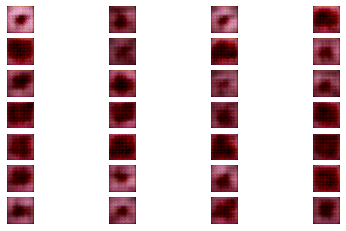

Training GAN at Time Step 1 of Epoch 8
1
****************** for time_step 1, discriminator loss is 0.6454162001609802 ***********************
****************** for time_step 1, generator loss is 3.0797572135925293 ***********************
Training GAN at Time Step 2 of Epoch 8
1
****************** for time_step 2, discriminator loss is 1.6030884981155396 ***********************
****************** for time_step 2, generator loss is 0.41443854570388794 ***********************
Training GAN at Time Step 3 of Epoch 8
1
****************** for time_step 3, discriminator loss is 3.6379945278167725 ***********************
****************** for time_step 3, generator loss is 7.4328083992004395 ***********************
Training GAN at Time Step 4 of Epoch 8
1
****************** for time_step 4, discriminator loss is 0.394386351108551 ***********************
****************** for time_step 4, generator loss is 2.2680153846740723 ***********************
Training GAN at Time Step 5 of Epoch 8
1
***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

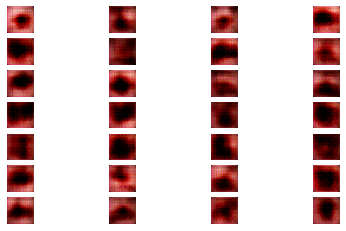

Training GAN at Time Step 1 of Epoch 9
1
****************** for time_step 1, discriminator loss is 0.5065165758132935 ***********************
****************** for time_step 1, generator loss is 1.2919764518737793 ***********************
Training GAN at Time Step 2 of Epoch 9
1
****************** for time_step 2, discriminator loss is 0.9760592579841614 ***********************
****************** for time_step 2, generator loss is 5.152357578277588 ***********************
Training GAN at Time Step 3 of Epoch 9
1
****************** for time_step 3, discriminator loss is 1.3041738271713257 ***********************
****************** for time_step 3, generator loss is 0.5134692192077637 ***********************
Training GAN at Time Step 4 of Epoch 9
1
****************** for time_step 4, discriminator loss is 1.025324821472168 ***********************
****************** for time_step 4, generator loss is 7.397313117980957 ***********************
Training GAN at Time Step 5 of Epoch 9
1
******

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

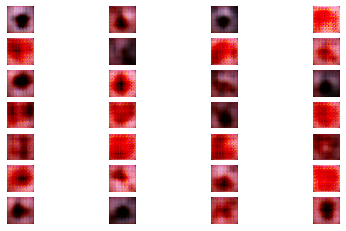

Training GAN at Time Step 1 of Epoch 10
1
****************** for time_step 1, discriminator loss is 0.4708007574081421 ***********************
****************** for time_step 1, generator loss is 1.9782471656799316 ***********************
Training GAN at Time Step 2 of Epoch 10
1
****************** for time_step 2, discriminator loss is 0.5535895824432373 ***********************
****************** for time_step 2, generator loss is 2.114494800567627 ***********************
Training GAN at Time Step 3 of Epoch 10
1
****************** for time_step 3, discriminator loss is 0.5288764834403992 ***********************
****************** for time_step 3, generator loss is 1.6952002048492432 ***********************
Training GAN at Time Step 4 of Epoch 10
1
****************** for time_step 4, discriminator loss is 0.38115036487579346 ***********************
****************** for time_step 4, generator loss is 2.9001176357269287 ***********************
Training GAN at Time Step 5 of Epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

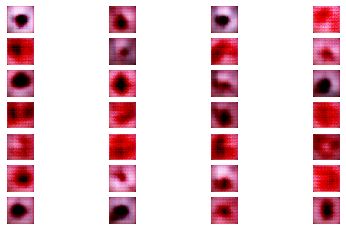

Training GAN at Time Step 1 of Epoch 11
1
****************** for time_step 1, discriminator loss is 0.3385085463523865 ***********************
****************** for time_step 1, generator loss is 2.9480514526367188 ***********************
Training GAN at Time Step 2 of Epoch 11
1
****************** for time_step 2, discriminator loss is 0.42336875200271606 ***********************
****************** for time_step 2, generator loss is 1.5454964637756348 ***********************
Training GAN at Time Step 3 of Epoch 11
1
****************** for time_step 3, discriminator loss is 0.5230154991149902 ***********************
****************** for time_step 3, generator loss is 3.289942502975464 ***********************
Training GAN at Time Step 4 of Epoch 11
1
****************** for time_step 4, discriminator loss is 0.573521077632904 ***********************
****************** for time_step 4, generator loss is 1.2453631162643433 ***********************
Training GAN at Time Step 5 of Epoch 11
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

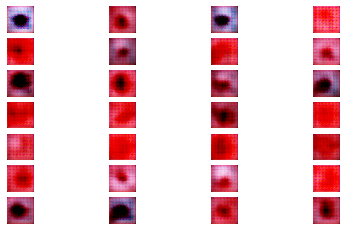

Training GAN at Time Step 1 of Epoch 12
1
****************** for time_step 1, discriminator loss is 0.7051689028739929 ***********************
****************** for time_step 1, generator loss is 1.4490423202514648 ***********************
Training GAN at Time Step 2 of Epoch 12
1
****************** for time_step 2, discriminator loss is 0.7411962747573853 ***********************
****************** for time_step 2, generator loss is 1.770528793334961 ***********************
Training GAN at Time Step 3 of Epoch 12
1
****************** for time_step 3, discriminator loss is 0.7862541675567627 ***********************
****************** for time_step 3, generator loss is 1.266679048538208 ***********************
Training GAN at Time Step 4 of Epoch 12
1
****************** for time_step 4, discriminator loss is 0.8136696815490723 ***********************
****************** for time_step 4, generator loss is 2.5407185554504395 ***********************
Training GAN at Time Step 5 of Epoch 12
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

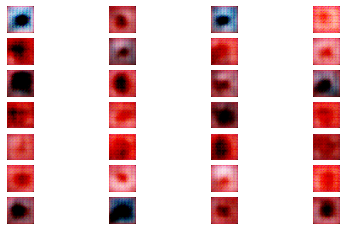

Training GAN at Time Step 1 of Epoch 13
1
****************** for time_step 1, discriminator loss is 1.161466121673584 ***********************
****************** for time_step 1, generator loss is 0.6638914346694946 ***********************
Training GAN at Time Step 2 of Epoch 13
1
****************** for time_step 2, discriminator loss is 0.8810185194015503 ***********************
****************** for time_step 2, generator loss is 3.968472480773926 ***********************
Training GAN at Time Step 3 of Epoch 13
1
****************** for time_step 3, discriminator loss is 0.6493968963623047 ***********************
****************** for time_step 3, generator loss is 1.4022142887115479 ***********************
Training GAN at Time Step 4 of Epoch 13
1
****************** for time_step 4, discriminator loss is 0.4768420159816742 ***********************
****************** for time_step 4, generator loss is 2.2762699127197266 ***********************
Training GAN at Time Step 5 of Epoch 13
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 13
1
****************** for time_step 28, discriminator loss is 0.4519411325454712 ***********************
****************** for time_step 28, generator loss is 2.0625557899475098 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

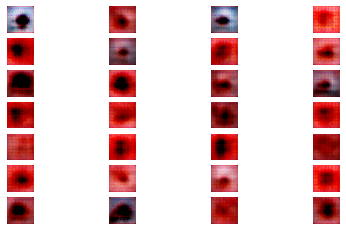

Training GAN at Time Step 1 of Epoch 14
1
****************** for time_step 1, discriminator loss is 0.6486796140670776 ***********************
****************** for time_step 1, generator loss is 1.575973629951477 ***********************
Training GAN at Time Step 2 of Epoch 14
1
****************** for time_step 2, discriminator loss is 0.6554830074310303 ***********************
****************** for time_step 2, generator loss is 2.1005444526672363 ***********************
Training GAN at Time Step 3 of Epoch 14
1
****************** for time_step 3, discriminator loss is 0.9758014678955078 ***********************
****************** for time_step 3, generator loss is 0.8132642507553101 ***********************
Training GAN at Time Step 4 of Epoch 14
1
****************** for time_step 4, discriminator loss is 2.2940094470977783 ***********************
****************** for time_step 4, generator loss is 4.933341026306152 ***********************
Training GAN at Time Step 5 of Epoch 14
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

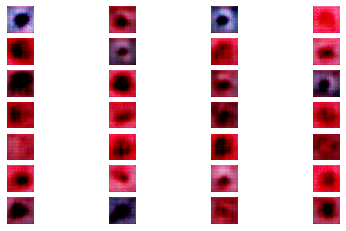

Training GAN at Time Step 1 of Epoch 15
1
****************** for time_step 1, discriminator loss is 0.511349081993103 ***********************
****************** for time_step 1, generator loss is 1.486830711364746 ***********************
Training GAN at Time Step 2 of Epoch 15
1
****************** for time_step 2, discriminator loss is 0.46749794483184814 ***********************
****************** for time_step 2, generator loss is 2.2395310401916504 ***********************
Training GAN at Time Step 3 of Epoch 15
1
****************** for time_step 3, discriminator loss is 0.6038005948066711 ***********************
****************** for time_step 3, generator loss is 1.703530192375183 ***********************
Training GAN at Time Step 4 of Epoch 15
1
****************** for time_step 4, discriminator loss is 0.5281383991241455 ***********************
****************** for time_step 4, generator loss is 1.8544659614562988 ***********************
Training GAN at Time Step 5 of Epoch 15
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

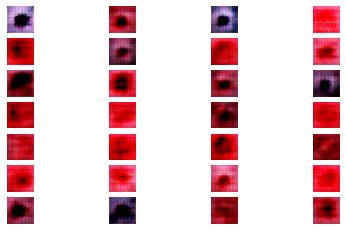

Training GAN at Time Step 1 of Epoch 16
1
****************** for time_step 1, discriminator loss is 0.7126721739768982 ***********************
****************** for time_step 1, generator loss is 0.9835345149040222 ***********************
Training GAN at Time Step 2 of Epoch 16
1
****************** for time_step 2, discriminator loss is 0.5164070725440979 ***********************
****************** for time_step 2, generator loss is 3.112635374069214 ***********************
Training GAN at Time Step 3 of Epoch 16
1
****************** for time_step 3, discriminator loss is 0.3512018918991089 ***********************
****************** for time_step 3, generator loss is 2.0770201683044434 ***********************
Training GAN at Time Step 4 of Epoch 16
1
****************** for time_step 4, discriminator loss is 0.3656635880470276 ***********************
****************** for time_step 4, generator loss is 1.9289242029190063 ***********************
Training GAN at Time Step 5 of Epoch 16
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 16
1
****************** for time_step 28, discriminator loss is 0.32748323678970337 ***********************
****************** for time_step 28, generator loss is 2.360950231552124 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

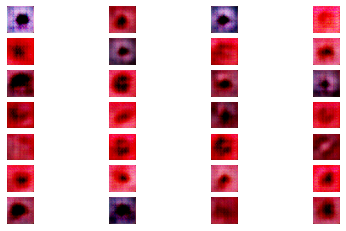

Training GAN at Time Step 1 of Epoch 17
1
****************** for time_step 1, discriminator loss is 0.47762128710746765 ***********************
****************** for time_step 1, generator loss is 1.6677721738815308 ***********************
Training GAN at Time Step 2 of Epoch 17
1
****************** for time_step 2, discriminator loss is 0.5342807769775391 ***********************
****************** for time_step 2, generator loss is 2.2988526821136475 ***********************
Training GAN at Time Step 3 of Epoch 17
1
****************** for time_step 3, discriminator loss is 0.7179343700408936 ***********************
****************** for time_step 3, generator loss is 1.2140913009643555 ***********************
Training GAN at Time Step 4 of Epoch 17
1
****************** for time_step 4, discriminator loss is 0.8094425201416016 ***********************
****************** for time_step 4, generator loss is 2.9823970794677734 ***********************
Training GAN at Time Step 5 of Epoch 17

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

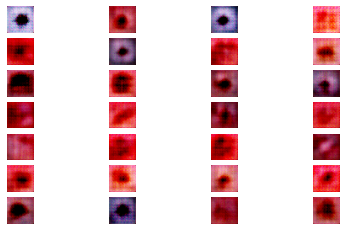

Training GAN at Time Step 1 of Epoch 18
1
****************** for time_step 1, discriminator loss is 0.6815586090087891 ***********************
****************** for time_step 1, generator loss is 1.4194916486740112 ***********************
Training GAN at Time Step 2 of Epoch 18
1
****************** for time_step 2, discriminator loss is 0.6870602965354919 ***********************
****************** for time_step 2, generator loss is 1.9136626720428467 ***********************
Training GAN at Time Step 3 of Epoch 18
1
****************** for time_step 3, discriminator loss is 0.650122880935669 ***********************
****************** for time_step 3, generator loss is 1.2444584369659424 ***********************
Training GAN at Time Step 4 of Epoch 18
1
****************** for time_step 4, discriminator loss is 0.7778350114822388 ***********************
****************** for time_step 4, generator loss is 2.6369717121124268 ***********************
Training GAN at Time Step 5 of Epoch 18
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 18
1
****************** for time_step 28, discriminator loss is 0.6719496250152588 ***********************
****************** for time_step 28, generator loss is 1.1709223985671997 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

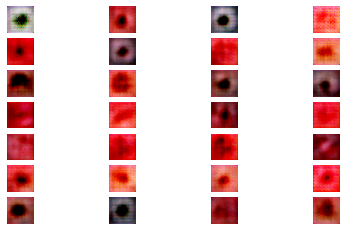

Training GAN at Time Step 1 of Epoch 19
1
****************** for time_step 1, discriminator loss is 0.6215795278549194 ***********************
****************** for time_step 1, generator loss is 2.2976598739624023 ***********************
Training GAN at Time Step 2 of Epoch 19
1
****************** for time_step 2, discriminator loss is 0.4667071998119354 ***********************
****************** for time_step 2, generator loss is 1.776907205581665 ***********************
Training GAN at Time Step 3 of Epoch 19
1
****************** for time_step 3, discriminator loss is 0.47583264112472534 ***********************
****************** for time_step 3, generator loss is 1.6737115383148193 ***********************
Training GAN at Time Step 4 of Epoch 19
1
****************** for time_step 4, discriminator loss is 0.5469958782196045 ***********************
****************** for time_step 4, generator loss is 2.543591022491455 ***********************
Training GAN at Time Step 5 of Epoch 19
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

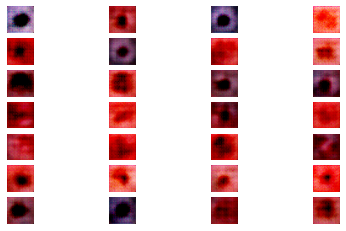

Training GAN at Time Step 1 of Epoch 20
1
****************** for time_step 1, discriminator loss is 1.1274713277816772 ***********************
****************** for time_step 1, generator loss is 3.5633487701416016 ***********************
Training GAN at Time Step 2 of Epoch 20
1
****************** for time_step 2, discriminator loss is 1.4252938032150269 ***********************
****************** for time_step 2, generator loss is 0.45902520418167114 ***********************
Training GAN at Time Step 3 of Epoch 20
1
****************** for time_step 3, discriminator loss is 1.0943140983581543 ***********************
****************** for time_step 3, generator loss is 3.613462448120117 ***********************
Training GAN at Time Step 4 of Epoch 20
1
****************** for time_step 4, discriminator loss is 0.751401424407959 ***********************
****************** for time_step 4, generator loss is 1.1595752239227295 ***********************
Training GAN at Time Step 5 of Epoch 20
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

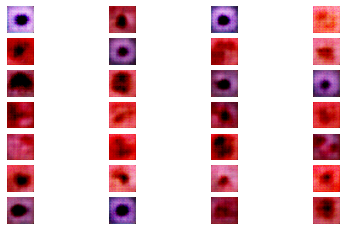

Training GAN at Time Step 1 of Epoch 21
1
****************** for time_step 1, discriminator loss is 0.48762720823287964 ***********************
****************** for time_step 1, generator loss is 1.627549648284912 ***********************
Training GAN at Time Step 2 of Epoch 21
1
****************** for time_step 2, discriminator loss is 0.6330740451812744 ***********************
****************** for time_step 2, generator loss is 1.5216931104660034 ***********************
Training GAN at Time Step 3 of Epoch 21
1
****************** for time_step 3, discriminator loss is 0.3806418776512146 ***********************
****************** for time_step 3, generator loss is 2.3068058490753174 ***********************
Training GAN at Time Step 4 of Epoch 21
1
****************** for time_step 4, discriminator loss is 0.4744781255722046 ***********************
****************** for time_step 4, generator loss is 2.214092254638672 ***********************
Training GAN at Time Step 5 of Epoch 21
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 21
1
****************** for time_step 28, discriminator loss is 0.6545374393463135 ***********************
****************** for time_step 28, generator loss is 1.627537727355957 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

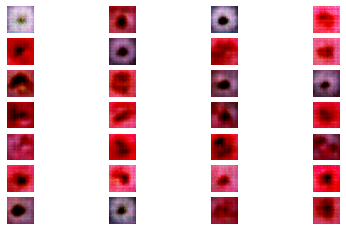

Training GAN at Time Step 1 of Epoch 22
1
****************** for time_step 1, discriminator loss is 0.5568912029266357 ***********************
****************** for time_step 1, generator loss is 1.421512246131897 ***********************
Training GAN at Time Step 2 of Epoch 22
1
****************** for time_step 2, discriminator loss is 0.5225153565406799 ***********************
****************** for time_step 2, generator loss is 2.5327863693237305 ***********************
Training GAN at Time Step 3 of Epoch 22
1
****************** for time_step 3, discriminator loss is 0.4973488450050354 ***********************
****************** for time_step 3, generator loss is 1.6707285642623901 ***********************
Training GAN at Time Step 4 of Epoch 22
1
****************** for time_step 4, discriminator loss is 0.4580748677253723 ***********************
****************** for time_step 4, generator loss is 1.8407902717590332 ***********************
Training GAN at Time Step 5 of Epoch 22
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 22
1
****************** for time_step 28, discriminator loss is 0.6032353639602661 ***********************
****************** for time_step 28, generator loss is 1.5781819820404053 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

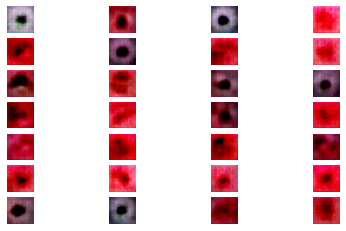

Training GAN at Time Step 1 of Epoch 23
1
****************** for time_step 1, discriminator loss is 0.6785545349121094 ***********************
****************** for time_step 1, generator loss is 1.5061230659484863 ***********************
Training GAN at Time Step 2 of Epoch 23
1
****************** for time_step 2, discriminator loss is 0.691169023513794 ***********************
****************** for time_step 2, generator loss is 1.890666127204895 ***********************
Training GAN at Time Step 3 of Epoch 23
1
****************** for time_step 3, discriminator loss is 0.895025372505188 ***********************
****************** for time_step 3, generator loss is 1.0870343446731567 ***********************
Training GAN at Time Step 4 of Epoch 23
1
****************** for time_step 4, discriminator loss is 1.0634422302246094 ***********************
****************** for time_step 4, generator loss is 2.2923269271850586 ***********************
Training GAN at Time Step 5 of Epoch 23
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

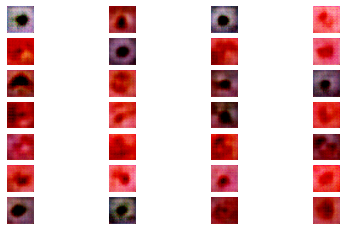

Training GAN at Time Step 1 of Epoch 24
1
****************** for time_step 1, discriminator loss is 0.576112687587738 ***********************
****************** for time_step 1, generator loss is 1.5233111381530762 ***********************
Training GAN at Time Step 2 of Epoch 24
1
****************** for time_step 2, discriminator loss is 0.6423118114471436 ***********************
****************** for time_step 2, generator loss is 2.444995880126953 ***********************
Training GAN at Time Step 3 of Epoch 24
1
****************** for time_step 3, discriminator loss is 0.8478649258613586 ***********************
****************** for time_step 3, generator loss is 0.9729090929031372 ***********************
Training GAN at Time Step 4 of Epoch 24
1
****************** for time_step 4, discriminator loss is 0.8612141609191895 ***********************
****************** for time_step 4, generator loss is 2.2822630405426025 ***********************
Training GAN at Time Step 5 of Epoch 24
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

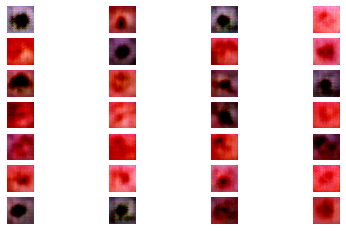

Training GAN at Time Step 1 of Epoch 25
1
****************** for time_step 1, discriminator loss is 0.6376249194145203 ***********************
****************** for time_step 1, generator loss is 1.8125659227371216 ***********************
Training GAN at Time Step 2 of Epoch 25
1
****************** for time_step 2, discriminator loss is 0.7679031491279602 ***********************
****************** for time_step 2, generator loss is 1.7201975584030151 ***********************
Training GAN at Time Step 3 of Epoch 25
1
****************** for time_step 3, discriminator loss is 0.907931387424469 ***********************
****************** for time_step 3, generator loss is 1.0938975811004639 ***********************
Training GAN at Time Step 4 of Epoch 25
1
****************** for time_step 4, discriminator loss is 0.9251365661621094 ***********************
****************** for time_step 4, generator loss is 1.9410970211029053 ***********************
Training GAN at Time Step 5 of Epoch 25
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 25
1
****************** for time_step 28, discriminator loss is 1.2042243480682373 ***********************
****************** for time_step 28, generator loss is 3.102806568145752 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

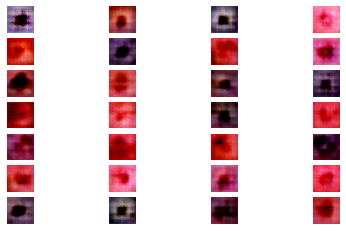

Training GAN at Time Step 1 of Epoch 26
1
****************** for time_step 1, discriminator loss is 0.8265315294265747 ***********************
****************** for time_step 1, generator loss is 1.0057505369186401 ***********************
Training GAN at Time Step 2 of Epoch 26
1
****************** for time_step 2, discriminator loss is 0.5993589162826538 ***********************
****************** for time_step 2, generator loss is 1.825034737586975 ***********************
Training GAN at Time Step 3 of Epoch 26
1
****************** for time_step 3, discriminator loss is 0.5303004384040833 ***********************
****************** for time_step 3, generator loss is 1.8629857301712036 ***********************
Training GAN at Time Step 4 of Epoch 26
1
****************** for time_step 4, discriminator loss is 0.663301944732666 ***********************
****************** for time_step 4, generator loss is 1.741260290145874 ***********************
Training GAN at Time Step 5 of Epoch 26
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

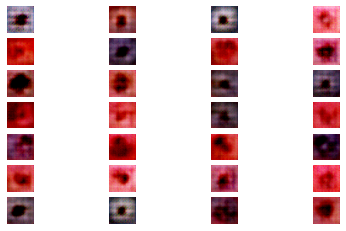

Training GAN at Time Step 1 of Epoch 27
1
****************** for time_step 1, discriminator loss is 1.3268790245056152 ***********************
****************** for time_step 1, generator loss is 3.018728256225586 ***********************
Training GAN at Time Step 2 of Epoch 27
1
****************** for time_step 2, discriminator loss is 1.623077630996704 ***********************
****************** for time_step 2, generator loss is 0.38545548915863037 ***********************
Training GAN at Time Step 3 of Epoch 27
1
****************** for time_step 3, discriminator loss is 1.1631200313568115 ***********************
****************** for time_step 3, generator loss is 2.540205240249634 ***********************
Training GAN at Time Step 4 of Epoch 27
1
****************** for time_step 4, discriminator loss is 0.80739825963974 ***********************
****************** for time_step 4, generator loss is 1.109691858291626 ***********************
Training GAN at Time Step 5 of Epoch 27
1
***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

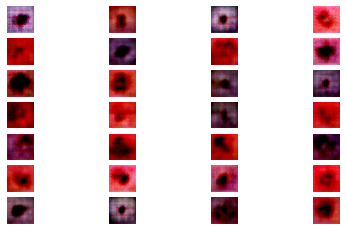

Training GAN at Time Step 1 of Epoch 28
1
****************** for time_step 1, discriminator loss is 0.7991765737533569 ***********************
****************** for time_step 1, generator loss is 1.451064944267273 ***********************
Training GAN at Time Step 2 of Epoch 28
1
****************** for time_step 2, discriminator loss is 0.7678828239440918 ***********************
****************** for time_step 2, generator loss is 1.5158697366714478 ***********************
Training GAN at Time Step 3 of Epoch 28
1
****************** for time_step 3, discriminator loss is 0.9612696766853333 ***********************
****************** for time_step 3, generator loss is 1.2488279342651367 ***********************
Training GAN at Time Step 4 of Epoch 28
1
****************** for time_step 4, discriminator loss is 0.8916273713111877 ***********************
****************** for time_step 4, generator loss is 1.4832631349563599 ***********************
Training GAN at Time Step 5 of Epoch 28
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

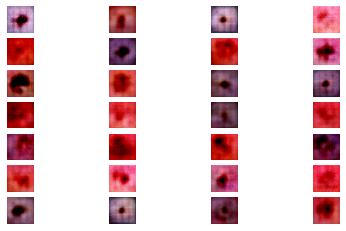

Training GAN at Time Step 1 of Epoch 29
1
****************** for time_step 1, discriminator loss is 1.2475754022598267 ***********************
****************** for time_step 1, generator loss is 0.6168404817581177 ***********************
Training GAN at Time Step 2 of Epoch 29
1
****************** for time_step 2, discriminator loss is 1.0549768209457397 ***********************
****************** for time_step 2, generator loss is 2.3361563682556152 ***********************
Training GAN at Time Step 3 of Epoch 29
1
****************** for time_step 3, discriminator loss is 1.287044882774353 ***********************
****************** for time_step 3, generator loss is 0.6772929430007935 ***********************
Training GAN at Time Step 4 of Epoch 29
1
****************** for time_step 4, discriminator loss is 1.1078081130981445 ***********************
****************** for time_step 4, generator loss is 2.04089617729187 ***********************
Training GAN at Time Step 5 of Epoch 29
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

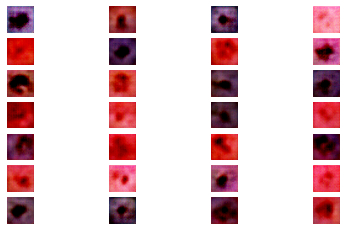

Training GAN at Time Step 1 of Epoch 30
1
****************** for time_step 1, discriminator loss is 1.0700336694717407 ***********************
****************** for time_step 1, generator loss is 0.8953847885131836 ***********************
Training GAN at Time Step 2 of Epoch 30
1
****************** for time_step 2, discriminator loss is 0.9788554310798645 ***********************
****************** for time_step 2, generator loss is 2.022900104522705 ***********************
Training GAN at Time Step 3 of Epoch 30
1
****************** for time_step 3, discriminator loss is 0.9007092714309692 ***********************
****************** for time_step 3, generator loss is 0.9599736928939819 ***********************
Training GAN at Time Step 4 of Epoch 30
1
****************** for time_step 4, discriminator loss is 0.966965913772583 ***********************
****************** for time_step 4, generator loss is 1.692435383796692 ***********************
Training GAN at Time Step 5 of Epoch 30
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

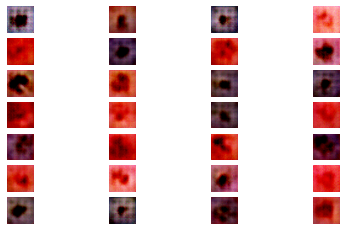

Training GAN at Time Step 1 of Epoch 31
1
****************** for time_step 1, discriminator loss is 1.0835411548614502 ***********************
****************** for time_step 1, generator loss is 0.8049519062042236 ***********************
Training GAN at Time Step 2 of Epoch 31
1
****************** for time_step 2, discriminator loss is 0.9112787246704102 ***********************
****************** for time_step 2, generator loss is 1.9328124523162842 ***********************
Training GAN at Time Step 3 of Epoch 31
1
****************** for time_step 3, discriminator loss is 0.865142822265625 ***********************
****************** for time_step 3, generator loss is 1.2469056844711304 ***********************
Training GAN at Time Step 4 of Epoch 31
1
****************** for time_step 4, discriminator loss is 0.7332050800323486 ***********************
****************** for time_step 4, generator loss is 1.2465686798095703 ***********************
Training GAN at Time Step 5 of Epoch 31
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

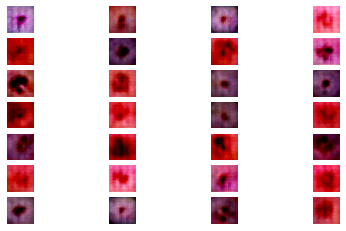

Training GAN at Time Step 1 of Epoch 32
1
****************** for time_step 1, discriminator loss is 1.1334506273269653 ***********************
****************** for time_step 1, generator loss is 2.290684461593628 ***********************
Training GAN at Time Step 2 of Epoch 32
1
****************** for time_step 2, discriminator loss is 1.1101343631744385 ***********************
****************** for time_step 2, generator loss is 0.6653501987457275 ***********************
Training GAN at Time Step 3 of Epoch 32
1
****************** for time_step 3, discriminator loss is 0.946119487285614 ***********************
****************** for time_step 3, generator loss is 2.172605514526367 ***********************
Training GAN at Time Step 4 of Epoch 32
1
****************** for time_step 4, discriminator loss is 0.8675460815429688 ***********************
****************** for time_step 4, generator loss is 1.1637849807739258 ***********************
Training GAN at Time Step 5 of Epoch 32
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

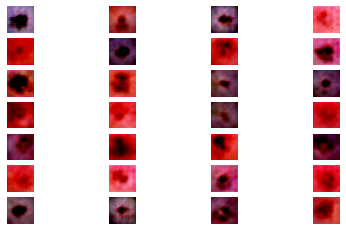

Training GAN at Time Step 1 of Epoch 33
1
****************** for time_step 1, discriminator loss is 0.8140522241592407 ***********************
****************** for time_step 1, generator loss is 1.6330634355545044 ***********************
Training GAN at Time Step 2 of Epoch 33
1
****************** for time_step 2, discriminator loss is 0.9119632840156555 ***********************
****************** for time_step 2, generator loss is 1.1098661422729492 ***********************
Training GAN at Time Step 3 of Epoch 33
1
****************** for time_step 3, discriminator loss is 0.8686449527740479 ***********************
****************** for time_step 3, generator loss is 1.6209667921066284 ***********************
Training GAN at Time Step 4 of Epoch 33
1
****************** for time_step 4, discriminator loss is 1.001819372177124 ***********************
****************** for time_step 4, generator loss is 0.8066441416740417 ***********************
Training GAN at Time Step 5 of Epoch 33
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

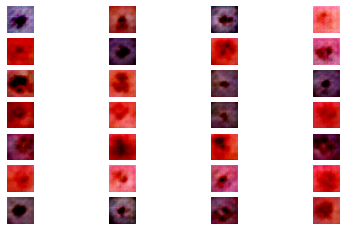

Training GAN at Time Step 1 of Epoch 34
1
****************** for time_step 1, discriminator loss is 0.9114530086517334 ***********************
****************** for time_step 1, generator loss is 2.011368989944458 ***********************
Training GAN at Time Step 2 of Epoch 34
1
****************** for time_step 2, discriminator loss is 1.0964164733886719 ***********************
****************** for time_step 2, generator loss is 0.7688722610473633 ***********************
Training GAN at Time Step 3 of Epoch 34
1
****************** for time_step 3, discriminator loss is 0.8642644882202148 ***********************
****************** for time_step 3, generator loss is 1.7453737258911133 ***********************
Training GAN at Time Step 4 of Epoch 34
1
****************** for time_step 4, discriminator loss is 0.891508936882019 ***********************
****************** for time_step 4, generator loss is 1.2708015441894531 ***********************
Training GAN at Time Step 5 of Epoch 34
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

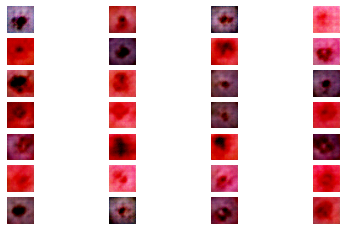

Training GAN at Time Step 1 of Epoch 35
1
****************** for time_step 1, discriminator loss is 1.4684292078018188 ***********************
****************** for time_step 1, generator loss is 0.4598071873188019 ***********************
Training GAN at Time Step 2 of Epoch 35
1
****************** for time_step 2, discriminator loss is 0.8518471121788025 ***********************
****************** for time_step 2, generator loss is 2.2102012634277344 ***********************
Training GAN at Time Step 3 of Epoch 35
1
****************** for time_step 3, discriminator loss is 0.8244580030441284 ***********************
****************** for time_step 3, generator loss is 1.3214741945266724 ***********************
Training GAN at Time Step 4 of Epoch 35
1
****************** for time_step 4, discriminator loss is 0.9966618418693542 ***********************
****************** for time_step 4, generator loss is 1.033599615097046 ***********************
Training GAN at Time Step 5 of Epoch 35
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 35
1
****************** for time_step 28, discriminator loss is 1.016264796257019 ***********************
****************** for time_step 28, generator loss is 0.7477163672447205 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

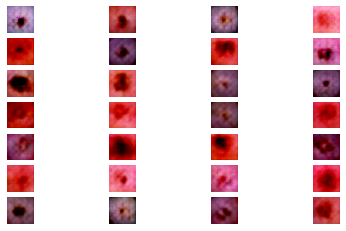

Training GAN at Time Step 1 of Epoch 36
1
****************** for time_step 1, discriminator loss is 0.7388729453086853 ***********************
****************** for time_step 1, generator loss is 1.8805820941925049 ***********************
Training GAN at Time Step 2 of Epoch 36
1
****************** for time_step 2, discriminator loss is 0.7479932308197021 ***********************
****************** for time_step 2, generator loss is 1.6537985801696777 ***********************
Training GAN at Time Step 3 of Epoch 36
1
****************** for time_step 3, discriminator loss is 0.9651371240615845 ***********************
****************** for time_step 3, generator loss is 1.0012482404708862 ***********************
Training GAN at Time Step 4 of Epoch 36
1
****************** for time_step 4, discriminator loss is 0.9475245475769043 ***********************
****************** for time_step 4, generator loss is 1.7229962348937988 ***********************
Training GAN at Time Step 5 of Epoch 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

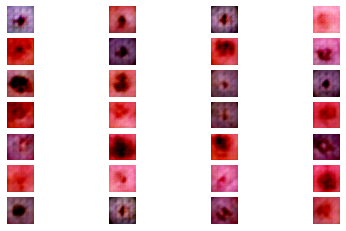

Training GAN at Time Step 1 of Epoch 37
1
****************** for time_step 1, discriminator loss is 2.0465424060821533 ***********************
****************** for time_step 1, generator loss is 0.2420690506696701 ***********************
Training GAN at Time Step 2 of Epoch 37
1
****************** for time_step 2, discriminator loss is 1.5579874515533447 ***********************
****************** for time_step 2, generator loss is 4.7062811851501465 ***********************
Training GAN at Time Step 3 of Epoch 37
1
****************** for time_step 3, discriminator loss is 0.694148063659668 ***********************
****************** for time_step 3, generator loss is 1.3358153104782104 ***********************
Training GAN at Time Step 4 of Epoch 37
1
****************** for time_step 4, discriminator loss is 1.1419446468353271 ***********************
****************** for time_step 4, generator loss is 0.6235573291778564 ***********************
Training GAN at Time Step 5 of Epoch 37
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 37
1
****************** for time_step 28, discriminator loss is 1.0867857933044434 ***********************
****************** for time_step 28, generator loss is 0.9961335062980652 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

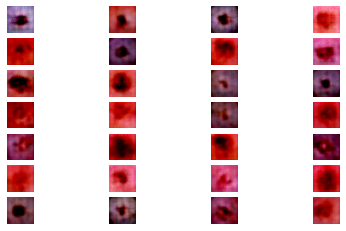

Training GAN at Time Step 1 of Epoch 38
1
****************** for time_step 1, discriminator loss is 1.2567044496536255 ***********************
****************** for time_step 1, generator loss is 1.1634371280670166 ***********************
Training GAN at Time Step 2 of Epoch 38
1
****************** for time_step 2, discriminator loss is 1.1281921863555908 ***********************
****************** for time_step 2, generator loss is 1.024622917175293 ***********************
Training GAN at Time Step 3 of Epoch 38
1
****************** for time_step 3, discriminator loss is 1.025946855545044 ***********************
****************** for time_step 3, generator loss is 1.4395382404327393 ***********************
Training GAN at Time Step 4 of Epoch 38
1
****************** for time_step 4, discriminator loss is 0.784151554107666 ***********************
****************** for time_step 4, generator loss is 1.3501282930374146 ***********************
Training GAN at Time Step 5 of Epoch 38
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


****************** for time_step 28, discriminator loss is 0.7519997358322144 ***********************
****************** for time_step 28, generator loss is 1.0941197872161865 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

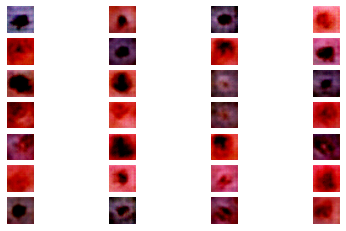

Training GAN at Time Step 1 of Epoch 39
1
****************** for time_step 1, discriminator loss is 0.5897276401519775 ***********************
****************** for time_step 1, generator loss is 1.9161441326141357 ***********************
Training GAN at Time Step 2 of Epoch 39
1
****************** for time_step 2, discriminator loss is 0.8145242929458618 ***********************
****************** for time_step 2, generator loss is 1.4118387699127197 ***********************
Training GAN at Time Step 3 of Epoch 39
1
****************** for time_step 3, discriminator loss is 1.0474638938903809 ***********************
****************** for time_step 3, generator loss is 0.9085019826889038 ***********************
Training GAN at Time Step 4 of Epoch 39
1
****************** for time_step 4, discriminator loss is 1.1290678977966309 ***********************
****************** for time_step 4, generator loss is 1.9705628156661987 ***********************
Training GAN at Time Step 5 of Epoch 39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 39
1
****************** for time_step 28, discriminator loss is 0.8667392134666443 ***********************
****************** for time_step 28, generator loss is 1.2328492403030396 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

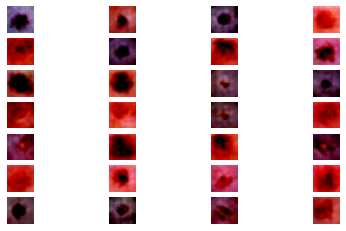

Training GAN at Time Step 1 of Epoch 40
1
****************** for time_step 1, discriminator loss is 0.9360033273696899 ***********************
****************** for time_step 1, generator loss is 1.5455045700073242 ***********************
Training GAN at Time Step 2 of Epoch 40
1
****************** for time_step 2, discriminator loss is 0.7872092127799988 ***********************
****************** for time_step 2, generator loss is 1.453761100769043 ***********************
Training GAN at Time Step 3 of Epoch 40
1
****************** for time_step 3, discriminator loss is 0.634409487247467 ***********************
****************** for time_step 3, generator loss is 1.5507094860076904 ***********************
Training GAN at Time Step 4 of Epoch 40
1
****************** for time_step 4, discriminator loss is 0.5904582142829895 ***********************
****************** for time_step 4, generator loss is 1.572759985923767 ***********************
Training GAN at Time Step 5 of Epoch 40
1
*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 40
1
****************** for time_step 28, discriminator loss is 1.1604769229888916 ***********************
****************** for time_step 28, generator loss is 1.3195775747299194 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

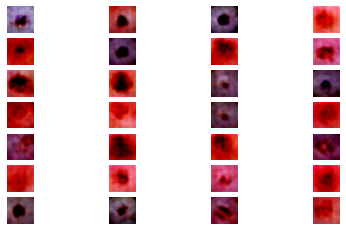

Training GAN at Time Step 1 of Epoch 41
1
****************** for time_step 1, discriminator loss is 1.408398985862732 ***********************
****************** for time_step 1, generator loss is 0.47068527340888977 ***********************
Training GAN at Time Step 2 of Epoch 41
1
****************** for time_step 2, discriminator loss is 1.3806170225143433 ***********************
****************** for time_step 2, generator loss is 2.2002811431884766 ***********************
Training GAN at Time Step 3 of Epoch 41
1
****************** for time_step 3, discriminator loss is 1.2847862243652344 ***********************
****************** for time_step 3, generator loss is 0.7517321705818176 ***********************
Training GAN at Time Step 4 of Epoch 41
1
****************** for time_step 4, discriminator loss is 1.0230066776275635 ***********************
****************** for time_step 4, generator loss is 1.2714067697525024 ***********************
Training GAN at Time Step 5 of Epoch 41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

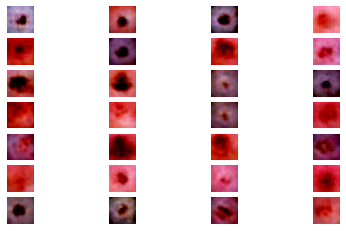

Training GAN at Time Step 1 of Epoch 42
1
****************** for time_step 1, discriminator loss is 1.1579359769821167 ***********************
****************** for time_step 1, generator loss is 0.6614019870758057 ***********************
Training GAN at Time Step 2 of Epoch 42
1
****************** for time_step 2, discriminator loss is 0.6542338132858276 ***********************
****************** for time_step 2, generator loss is 2.1726486682891846 ***********************
Training GAN at Time Step 3 of Epoch 42
1
****************** for time_step 3, discriminator loss is 0.7420969009399414 ***********************
****************** for time_step 3, generator loss is 1.514983892440796 ***********************
Training GAN at Time Step 4 of Epoch 42
1
****************** for time_step 4, discriminator loss is 0.9173914194107056 ***********************
****************** for time_step 4, generator loss is 1.0964325666427612 ***********************
Training GAN at Time Step 5 of Epoch 42
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


****************** for time_step 27, generator loss is 1.571061134338379 ***********************
Training GAN at Time Step 28 of Epoch 42
1
****************** for time_step 28, discriminator loss is 0.7188498973846436 ***********************
****************** for time_step 28, generator loss is 1.2521295547485352 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

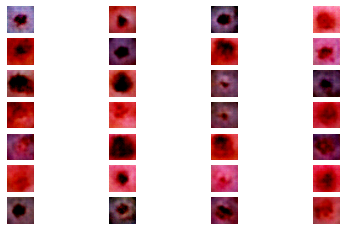

Training GAN at Time Step 1 of Epoch 43
1
****************** for time_step 1, discriminator loss is 0.971089243888855 ***********************
****************** for time_step 1, generator loss is 1.7022135257720947 ***********************
Training GAN at Time Step 2 of Epoch 43
1
****************** for time_step 2, discriminator loss is 1.215192198753357 ***********************
****************** for time_step 2, generator loss is 0.7136979103088379 ***********************
Training GAN at Time Step 3 of Epoch 43
1
****************** for time_step 3, discriminator loss is 1.521966814994812 ***********************
****************** for time_step 3, generator loss is 1.91312575340271 ***********************
Training GAN at Time Step 4 of Epoch 43
1
****************** for time_step 4, discriminator loss is 1.5097652673721313 ***********************
****************** for time_step 4, generator loss is 0.4293537437915802 ***********************
Training GAN at Time Step 5 of Epoch 43
1
***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

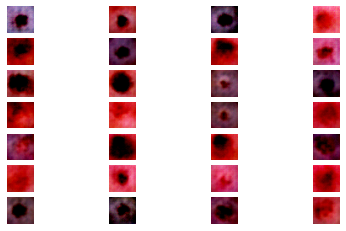

Training GAN at Time Step 1 of Epoch 44
1
****************** for time_step 1, discriminator loss is 0.7343844175338745 ***********************
****************** for time_step 1, generator loss is 1.3064417839050293 ***********************
Training GAN at Time Step 2 of Epoch 44
1
****************** for time_step 2, discriminator loss is 0.7321176528930664 ***********************
****************** for time_step 2, generator loss is 1.6989035606384277 ***********************
Training GAN at Time Step 3 of Epoch 44
1
****************** for time_step 3, discriminator loss is 0.9275562763214111 ***********************
****************** for time_step 3, generator loss is 0.9220449328422546 ***********************
Training GAN at Time Step 4 of Epoch 44
1
****************** for time_step 4, discriminator loss is 1.2928045988082886 ***********************
****************** for time_step 4, generator loss is 1.7900428771972656 ***********************
Training GAN at Time Step 5 of Epoch 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

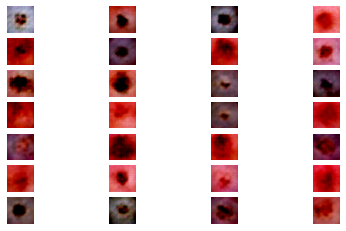

Training GAN at Time Step 1 of Epoch 45
1
****************** for time_step 1, discriminator loss is 0.941605269908905 ***********************
****************** for time_step 1, generator loss is 0.9766725301742554 ***********************
Training GAN at Time Step 2 of Epoch 45
1
****************** for time_step 2, discriminator loss is 0.91707843542099 ***********************
****************** for time_step 2, generator loss is 1.5693862438201904 ***********************
Training GAN at Time Step 3 of Epoch 45
1
****************** for time_step 3, discriminator loss is 1.008012056350708 ***********************
****************** for time_step 3, generator loss is 1.0162098407745361 ***********************
Training GAN at Time Step 4 of Epoch 45
1
****************** for time_step 4, discriminator loss is 0.8324936628341675 ***********************
****************** for time_step 4, generator loss is 1.4567430019378662 ***********************
Training GAN at Time Step 5 of Epoch 45
1
**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 45
1
****************** for time_step 28, discriminator loss is 1.1773741245269775 ***********************
****************** for time_step 28, generator loss is 1.6786737442016602 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

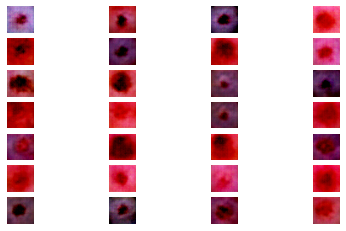

Training GAN at Time Step 1 of Epoch 46
1
****************** for time_step 1, discriminator loss is 1.2928491830825806 ***********************
****************** for time_step 1, generator loss is 0.6303794384002686 ***********************
Training GAN at Time Step 2 of Epoch 46
1
****************** for time_step 2, discriminator loss is 0.9607980251312256 ***********************
****************** for time_step 2, generator loss is 2.2889652252197266 ***********************
Training GAN at Time Step 3 of Epoch 46
1
****************** for time_step 3, discriminator loss is 0.8005349636077881 ***********************
****************** for time_step 3, generator loss is 1.1741061210632324 ***********************
Training GAN at Time Step 4 of Epoch 46
1
****************** for time_step 4, discriminator loss is 0.730232834815979 ***********************
****************** for time_step 4, generator loss is 1.428917407989502 ***********************
Training GAN at Time Step 5 of Epoch 46
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

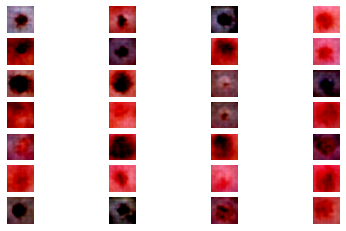

Training GAN at Time Step 1 of Epoch 47
1
****************** for time_step 1, discriminator loss is 0.7649828195571899 ***********************
****************** for time_step 1, generator loss is 1.5747120380401611 ***********************
Training GAN at Time Step 2 of Epoch 47
1
****************** for time_step 2, discriminator loss is 0.8851781487464905 ***********************
****************** for time_step 2, generator loss is 1.2922565937042236 ***********************
Training GAN at Time Step 3 of Epoch 47
1
****************** for time_step 3, discriminator loss is 0.9512128233909607 ***********************
****************** for time_step 3, generator loss is 1.2831605672836304 ***********************
Training GAN at Time Step 4 of Epoch 47
1
****************** for time_step 4, discriminator loss is 1.0869141817092896 ***********************
****************** for time_step 4, generator loss is 1.347985863685608 ***********************
Training GAN at Time Step 5 of Epoch 47
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 47
1
****************** for time_step 28, discriminator loss is 1.0763896703720093 ***********************
****************** for time_step 28, generator loss is 1.5260463953018188 ***********************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

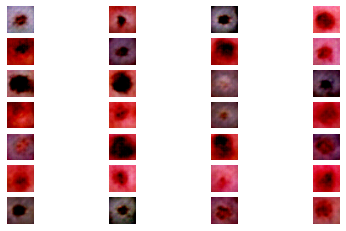

Training GAN at Time Step 1 of Epoch 48
1
****************** for time_step 1, discriminator loss is 0.9981005191802979 ***********************
****************** for time_step 1, generator loss is 0.8218702077865601 ***********************
Training GAN at Time Step 2 of Epoch 48
1
****************** for time_step 2, discriminator loss is 1.1218141317367554 ***********************
****************** for time_step 2, generator loss is 2.0808022022247314 ***********************
Training GAN at Time Step 3 of Epoch 48
1
****************** for time_step 3, discriminator loss is 1.2608156204223633 ***********************
****************** for time_step 3, generator loss is 0.6816548705101013 ***********************
Training GAN at Time Step 4 of Epoch 48
1
****************** for time_step 4, discriminator loss is 1.0351200103759766 ***********************
****************** for time_step 4, generator loss is 2.251328945159912 ***********************
Training GAN at Time Step 5 of Epoch 48
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

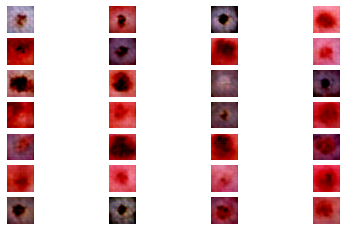

Training GAN at Time Step 1 of Epoch 49
1
****************** for time_step 1, discriminator loss is 1.0183086395263672 ***********************
****************** for time_step 1, generator loss is 0.8886210918426514 ***********************
Training GAN at Time Step 2 of Epoch 49
1
****************** for time_step 2, discriminator loss is 0.7153014540672302 ***********************
****************** for time_step 2, generator loss is 1.6445331573486328 ***********************
Training GAN at Time Step 3 of Epoch 49
1
****************** for time_step 3, discriminator loss is 0.7970994710922241 ***********************
****************** for time_step 3, generator loss is 1.5023753643035889 ***********************
Training GAN at Time Step 4 of Epoch 49
1
****************** for time_step 4, discriminator loss is 1.004513144493103 ***********************
****************** for time_step 4, generator loss is 0.9688867330551147 ***********************
Training GAN at Time Step 5 of Epoch 49
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

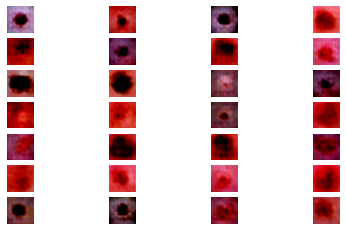

Training GAN at Time Step 1 of Epoch 50
1
****************** for time_step 1, discriminator loss is 0.8602124452590942 ***********************
****************** for time_step 1, generator loss is 2.8181841373443604 ***********************
Training GAN at Time Step 2 of Epoch 50
1
****************** for time_step 2, discriminator loss is 1.3866833448410034 ***********************
****************** for time_step 2, generator loss is 0.5640968084335327 ***********************
Training GAN at Time Step 3 of Epoch 50
1
****************** for time_step 3, discriminator loss is 1.7368757724761963 ***********************
****************** for time_step 3, generator loss is 2.033827543258667 ***********************
Training GAN at Time Step 4 of Epoch 50
1
****************** for time_step 4, discriminator loss is 2.021920680999756 ***********************
****************** for time_step 4, generator loss is 0.26683613657951355 ***********************
Training GAN at Time Step 5 of Epoch 50
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

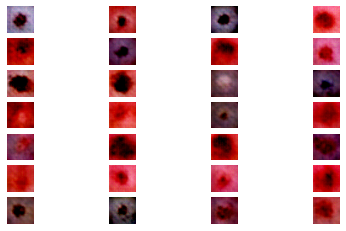

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

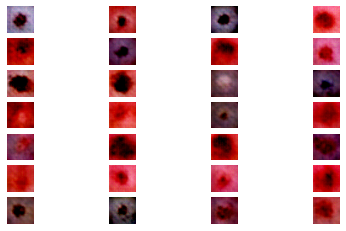

In [24]:
train_gan(real_imgs_datagen=train_dataset,total_epochs=GAN_epochs)

In [25]:
latest_checkpoint_path = tf.train.latest_checkpoint("/content/drive/MyDrive/GAN_training_checkpoints")
latest_checkpoint_path

'/content/drive/MyDrive/GAN_training_checkpoints/ckpt-1'

In [26]:
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

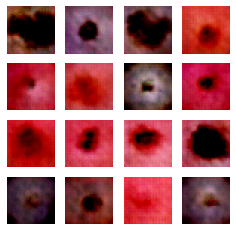

In [27]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [28]:
unlbld_imgs_base_path = "/content/drive/MyDrive/MelanomaDetection/unlabeled"
imgs_names_list = os.listdir(unlbld_imgs_base_path)
total_imgs = len(imgs_names_list)

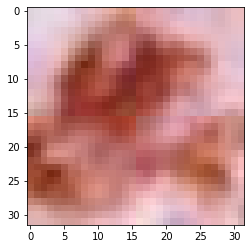

In [29]:
# real img
single_img = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))
plt.imshow(single_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


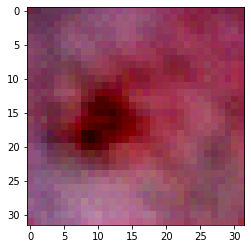

In [30]:
# img by Gen...
single_fake_img = G(tf.random.normal(shape=(1,100)))
plt.imshow(single_fake_img[0,:,:,:])

In [31]:
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

In [32]:
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [33]:
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [34]:
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)

In [35]:
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_test_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [36]:
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

def supervised_cls_loss(imgs_labels,imgs_preds):

  return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [37]:
@tf.function
def ssl_training_step(labeled_images,unlabeled_images):

  G.trainable = False
  unsupervised_cls.trainable = True
  supervised_cls.trainable = True

  with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

    labeled_imgs_preds = supervised_cls(labeled_images[0],training=True)
    
    supervised_loss = supervised_cls_loss(imgs_labels=labeled_images[1],imgs_preds=labeled_imgs_preds)

    gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
    supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_images = G(noise,training=False)

    real_imgs_preds = unsupervised_cls(unlabeled_images,training=True)
    fake_imgs_preds = unsupervised_cls(generated_images,training=True)

    unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
    unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

    # supervised_cls.trainable = False
    # unsupervised_cls.trainable = False

  return supervised_loss,labeled_imgs_preds

In [38]:
# # creating subfolder for training data

# train_dir = '/content/drive/MyDrive/MelanomaDetection/labeled'

# zero_labeled_folder = os.path.join(train_dir,'zero_labeled_folder')

# one_labeled_folder = os.path.join(train_dir,'one_labeled_folder')

# os.mkdir(one_labeled_folder)

# os.mkdir(zero_labeled_folder)

# labeled_data_path = "/content/drive/MyDrive/MelanomaDetection/labeled"

# for img_filename in os.listdir(labeled_data_path):
#       if img_filename.endswith("0.jpg"):
#         shutil.move(os.path.join(train_dir,img_filename),os.path.join(zero_labeled_folder,img_filename))

#       elif img_filename.endswith("1.jpg"):
#         shutil.move(os.path.join(train_dir,img_filename),os.path.join(one_labeled_folder,img_filename))



In [39]:
# # creating subfolder for teating_data

# test_dir = '/content/drive/MyDrive/MelanomaDetection/test'

# zero_test_folder = os.path.join(test_dir,'zero_test_folder')

# one_test_folder = os.path.join(test_dir,'one_test_folder')

# os.mkdir(one_test_folder)

# os.mkdir(zero_test_folder)

# test_data_path = "/content/drive/MyDrive/MelanomaDetection/test"

# for img_filename in os.listdir(test_data_path):
#       if img_filename.endswith("0.jpg"):
#         shutil.move(os.path.join(test_dir,img_filename),os.path.join(zero_test_folder,img_filename))

#       elif img_filename.endswith("1.jpg"):
#         shutil.move(os.path.join(test_dir,img_filename),os.path.join(one_test_folder,img_filename))

In [40]:
cls_checkpoint_dir = "/content/drive/MyDrive/pure_supervised_cls_checkpoints_melanoma"
checkpoint_prefix = os.path.join(cls_checkpoint_dir,"ckpt")
cls_checkpoint = tf.train.Checkpoint(optimizer=[supervised_cls_optimizer,unsupervised_cls_optimizer],
                                     model=[supervised_cls,unsupervised_cls])

In [41]:
cls_epochs = 25

In [42]:
cv_data_gen = ImageDataGenerator()

In [43]:
cv_datagen = cv_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/test",
                                             target_size=(32,32),
                                             classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/test"),
                                             class_mode="binary",batch_size=150)

Found 600 images belonging to 2 classes.


In [44]:
labeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)

In [45]:
labeled_datagen = labeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/labeled",
                                                       target_size=(32,32),
                                                       classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/labeled"),
                                                       class_mode="binary",batch_size=7)

Found 200 images belonging to 2 classes.


In [46]:
def train_ssl_classifier(labeled_imgs_datagen,unlabeled_imgs_datagen,cv_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for labeled_images_batch, unlabeled_images_batch in zip(labeled_imgs_datagen,unlabeled_imgs_datagen):

      supervised_loss, labeled_imgs_preds = ssl_training_step(labeled_images=labeled_images_batch,unlabeled_images=unlabeled_images_batch[0])

      if time_step > len(os.listdir("/content/drive/MyDrive/MelanomaDetection/unlabeled"))//batch_size:
        break

      supervised_cls_train_acc_metric.update_state(labeled_images_batch[1],labeled_imgs_preds)
      print("Training Loss at Time Step {} of Epoch {} is {}".format(time_step,epoch+1,float(supervised_loss)))

      time_step = time_step + 1

    training_accuracy = supervised_cls_train_acc_metric.result()
    print("\nTraining Accuracy after Epoch {} is {}".format(epoch+1,float(training_accuracy)))

    supervised_cls_train_acc_metric.reset_states()

    cv_time_steps = 0

    for X_cv,Y_cv_labels in cv_imgs_datagen:

      if cv_time_steps > 300//150:
        break

      cv_time_steps = cv_time_steps + 1

      Y_cv_preds = supervised_cls(X_cv,training=False)
      supervised_cls_cv_acc_metric.update_state(Y_cv_labels,Y_cv_preds)

    cv_accuracy = supervised_cls_cv_acc_metric.result()
    print("Corss Validation Accuracy after Epoch {} is {}\n".format(epoch+1,float(cv_accuracy)))

    supervised_cls_cv_acc_metric.reset_states()

    cls_checkpoint.save(file_prefix=checkpoint_prefix)

In [47]:
train_ssl_classifier(labeled_imgs_datagen=labeled_datagen,unlabeled_imgs_datagen=unlabeled_datagen,
                     cv_imgs_datagen=cv_datagen,total_epochs=cls_epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Training Loss at Time Step 1 of Epoch 1 is 0.5223940014839172
Training Loss at Time Step 2 of Epoch 1 is 0.7821282744407654
Training Loss at Time Step 3 of Epoch 1 is 0.6415797472000122
Training Loss at Time Step 4 of Epoch 1 is 0.7428159117698669
Training Loss at Time Step 5 of Epoch 1 is 0.6643711924552917
Training Loss at Time Step 6 of Epoch 1 is 0.6793702244758606
Training Loss at Time Step 7 of Epoch 1 is 0.7417289614677429
Training Loss at Time Step 8 of Epoch 1 is 0.6610665917396545
Training Loss at Time Step 9 of Epoch 1 is 0.6409357190132141
Training Loss at Time Step 10 of Epoch 1 is 0.6352152228355408
Training Loss at Time Step 11 of Epoch 1 is 0.5905974507331848
Training Loss at Time Step 12 of Epoch 1 is 0.7627838850021362
Training Loss at Time Step 13 of Epoch 1 is 0.689515233039856
Training Loss at Time Step 14 of Epoch 1 is 0.6106863021850586
Training Loss at Time Step 15 of Epoch 1 is 0.6628469824790955
Training Loss at Time Step 16 of Epoch 1 is 0.6139609217643738
Tr

In [48]:
test_data_generator = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)

In [49]:
test_datagen = test_data_generator.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/test",
                                                        target_size=(32,32),
                                                       classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/test"),
                                                       class_mode="binary",batch_size=600)

Found 600 images belonging to 2 classes.


In [50]:
test_pred = supervised_cls(test_datagen[0][0])

In [51]:
supervised_cls_test_acc_metric.update_state(test_datagen[0][1],test_pred)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [53]:
float(supervised_cls_test_acc_metric.result())  

0.753333330154419